# Regresión Lineal Múltiple y LASSO

### Students grades

[Source Information](https://www.kaggle.com/hely333/what-is-the-secret-of-academic-success/data)
P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

In [1]:
# Se cargan las librerías que se van a utilizar
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale

In [2]:
pd.set_option('display.max_columns', 33) # by default is 10, if change to None print ALL

In [3]:
## 1) EXTRAER DATOS
df = pd.read_csv('student_mat.csv')
print(df.shape)

(395, 33)


In [4]:
## 2) ANÁLISIS EXPLORATORIO
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


Los datos corresponden a 395 estudiantes de 15 a 22 años que están en un curso de Matemáticas.

La información que se tiene de cada uno de los estudiantes es (33 columnas):

   - **school :** _GP:_ Gabriel Pereira, _MS:_ Mousinho da Silveira
   - **sex:** _F:_ female, _M:_ male
   - **age:** student's age (15-22)
   - **address:** _U:_ urban, _R:_ rural
   - **famsize:**  'LE3' - less or equal to 3 or 'GT3' - greater than 3
   - **Pstatus:** 'T' - living together or 'A' - apart
   - **Medu:** mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
   - **Fedu:** father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
   - **Mjob:** mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
   - **Fjob:** father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
   - **reason:** reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
   - **guardian:** student's guardian (nominal: 'mother', 'father' or 'other')
   - **traveltime:** home to school travel time (numeric: 1 - 4 hours)
   - **studytime:** weekly study time (numeric: 1 - 10 hours)
   - **failures:** number of past class failures (numeric: n if 1<=n<3, else 4)
   - **schoolsup:** extra educational support (binary: yes or no)
   - **famsup:** family educational support (binary: yes or no)
   - **paid:** extra paid classes within the course subject (Math) (binary: yes or no)
   - **activities:** extra-curricular activities (binary: yes or no)
   - **nursery:** attended nursery school (binary: yes or no)
   - **higher:** wants to take higher education (binary: yes or no)
   - **internet:** Internet access at home (binary: yes or no)
   - **romantic:** with a romantic relationship (binary: yes or no)
   - **famrel:** quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
   - **freetime:** free time after school (numeric: from 1 - very low to 5 - very high)
   - **goout:** going out with friends (numeric: from 1 - very low to 5 - very high)
   - **Dalc:** workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
   - **Walc:** weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
   - **health:** current health status (numeric: from 1 - very bad to 5 - very good)
   - **absences:** number of school absences (numeric: from 0 to 93)
   - **G1:** first period grade (numeric: from 0 to 20)
   - **G2:** second period grade (numeric: from 0 to 20)
   - **G3:** final grade (numeric: from 0 to 20, output target)
 

#### Se busca estimar la calificación final: _G3_.

<!---
   - **school :** Escuela a la que pertenecen los estudiantes. _GP:_ Gabriel Pereira, _MS:_ Mousinho da Silveira.
   - **sex:** _F:_ femenino, _M:_ masculino.
   - **age:** Variable numérica (15-22).
   - **address:** _U:_ Zona urbana, _R:_ Zona rural.
   - **famsize:** Tamaño de la familia. _LE3:_ Si <= 3, _GT3:_ Si >3.
   - **Pstatus:** T: Si vive con sus padres, A: Si vive aparte.
   - **Medu:** Educación de la madre. 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education
   - **Fedu:** Educación del padre.

-->

In [5]:
# Se cuenta el número de NaN's por columna
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [6]:
# Se definen las varibles X (predictoras) y Y (dependiente)
Y = df.G3
X = df.drop(['G3'], axis = 1)
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10


Antes de convertir las variables categóricas a variables dummies, vamos a ver algunas gráficas para decidir cuáles vamos a utilizar en la regresión.

C:\Users\miri_\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frecuencia relativa')

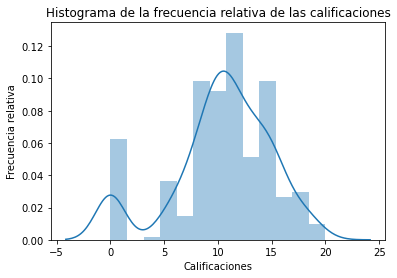

In [7]:
## 3) VISUALIZACIÓN DE LOS DATOS
#Histograma de la frecuencia relativa del salario con la densidad ajustada correspondiente.
sns.distplot(Y)
plt.title('Histograma de la frecuencia relativa de las calificaciones')
plt.xlabel('Calificaciones')
plt.ylabel('Frecuencia relativa')

F    208
M    187
Name: sex, dtype: int64


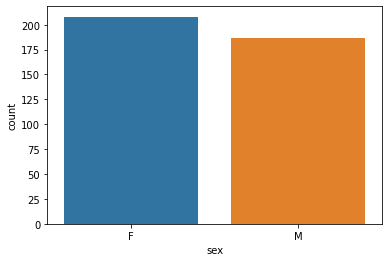

In [8]:
print(df['sex'].value_counts())
sns.countplot(x='sex', data=df)
plt.show()

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64


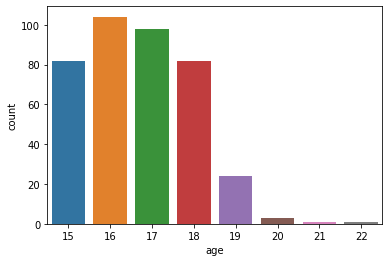

In [9]:
print(df['age'].value_counts())
sns.countplot(x='age', data=df)
plt.show()

U    307
R     88
Name: address, dtype: int64


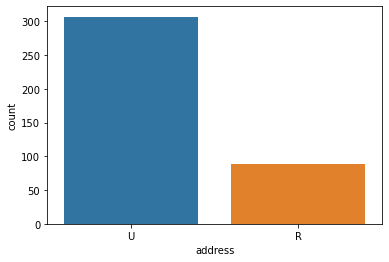

In [10]:
print(df['address'].value_counts())
sns.countplot(x='address', data=df)
plt.show()

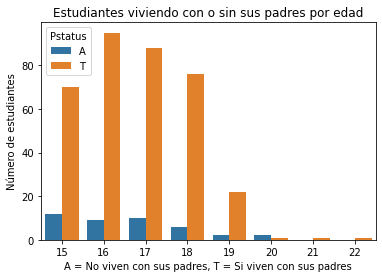

In [11]:
sns.countplot(x='age', hue='Pstatus', data=df)
plt.title('Estudiantes viviendo con o sin sus padres por edad')
plt.xlabel('A = No viven con sus padres, T = Si viven con sus padres')
plt.ylabel('Número de estudiantes')
plt.show()

4    131
2    103
3     99
1     59
0      3
Name: Medu, dtype: int64


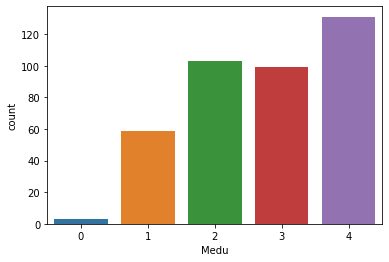

In [12]:
# numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education
print(df['Medu'].value_counts())
sns.countplot(x='Medu', data=df)
plt.show()

2    115
3    100
4     96
1     82
0      2
Name: Fedu, dtype: int64


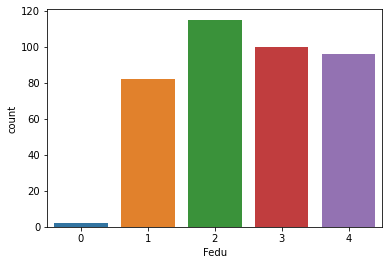

In [13]:
# numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education
print(df['Fedu'].value_counts())
sns.countplot(x='Fedu', data=df)
plt.show()

other       141
services    103
at_home      59
teacher      58
health       34
Name: Mjob, dtype: int64


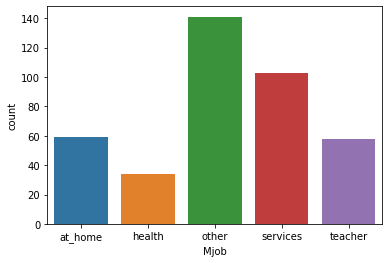

In [14]:
# (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
print(df['Mjob'].value_counts())
sns.countplot(x='Mjob', data=df)
plt.show()

other       217
services    111
teacher      29
at_home      20
health       18
Name: Fjob, dtype: int64


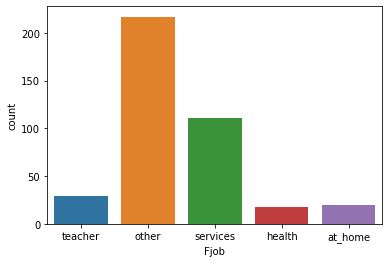

In [15]:
# (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
print(df['Fjob'].value_counts())
sns.countplot(x='Fjob', data=df)
plt.show()

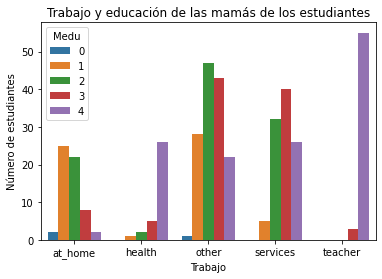

In [16]:
# numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education
sns.countplot(x='Mjob', hue='Medu', data=df)
plt.title('Trabajo y educación de las mamás de los estudiantes')
plt.xlabel('Trabajo')
plt.ylabel('Número de estudiantes')
plt.show()

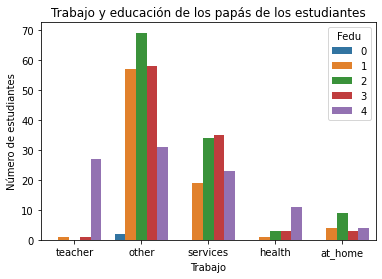

In [17]:
sns.countplot(x='Fjob', hue='Fedu', data=df)
plt.title('Trabajo y educación de los papás de los estudiantes')
plt.xlabel('Trabajo')
plt.ylabel('Número de estudiantes')
plt.show()

course        145
home          109
reputation    105
other          36
Name: reason, dtype: int64


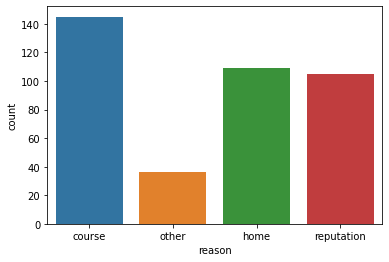

In [18]:
# reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
print(df['reason'].value_counts())
sns.countplot(x='reason', data=df)
plt.show()

mother    273
father     90
other      32
Name: guardian, dtype: int64


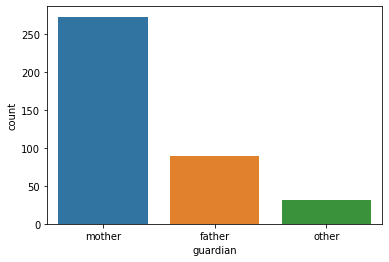

In [19]:
print(df['guardian'].value_counts())
sns.countplot(x='guardian', data=df)
plt.show()

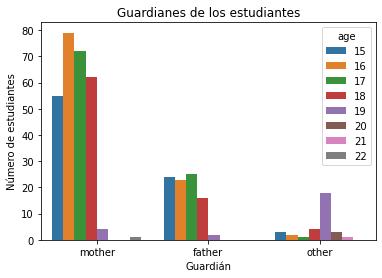

In [20]:
sns.countplot(x='guardian', hue='age', data=df)
plt.title('Guardianes de los estudiantes')
plt.xlabel('Guardián')
plt.ylabel('Número de estudiantes')
plt.show()

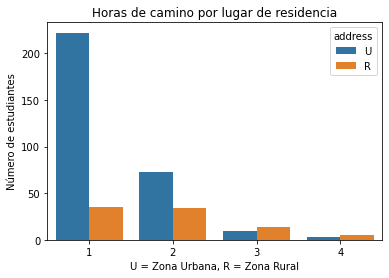

In [21]:
sns.countplot(x='traveltime', hue='address', data=df)
plt.title('Horas de camino por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

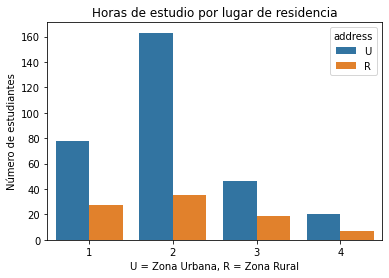

In [22]:
sns.countplot(x='studytime', hue='address', data=df)
plt.title('Horas de estudio por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

0    312
1     50
2     17
3     16
Name: failures, dtype: int64


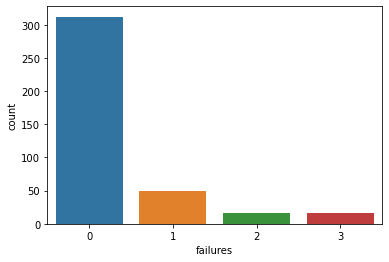

In [23]:
print(df['failures'].value_counts())
sns.countplot(x='failures', data=df)
plt.show()

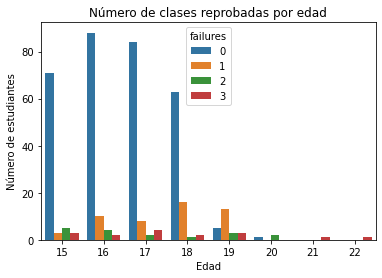

In [24]:
sns.countplot(x='age', hue='failures', data=df)
plt.title('Número de clases reprobadas por edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

no     344
yes     51
Name: schoolsup, dtype: int64


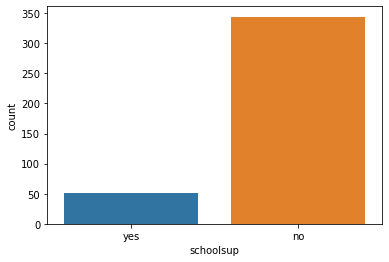

In [25]:
print(df['schoolsup'].value_counts())
sns.countplot(x='schoolsup', data=df)
plt.show()

yes    242
no     153
Name: famsup, dtype: int64


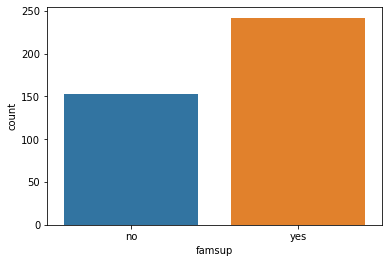

In [26]:
print(df['famsup'].value_counts())
sns.countplot(x='famsup', data=df)
plt.show()

no     214
yes    181
Name: paid, dtype: int64


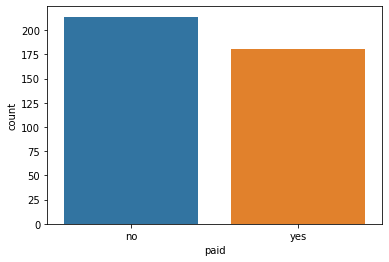

In [27]:
print(df['paid'].value_counts())
sns.countplot(x='paid', data=df)
plt.show()

yes    201
no     194
Name: activities, dtype: int64


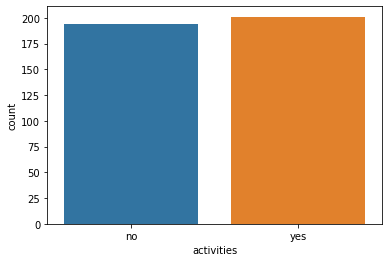

In [28]:
print(df['activities'].value_counts())
sns.countplot(x='activities', data=df)
plt.show()

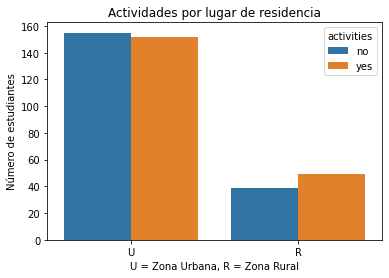

In [29]:
sns.countplot(x='address', hue='activities', data=df)
plt.title('Actividades por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

yes    314
no      81
Name: nursery, dtype: int64


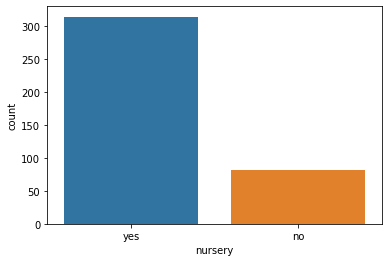

In [30]:
print(df['nursery'].value_counts())
sns.countplot(x='nursery', data=df)
plt.show()

yes    375
no      20
Name: higher, dtype: int64


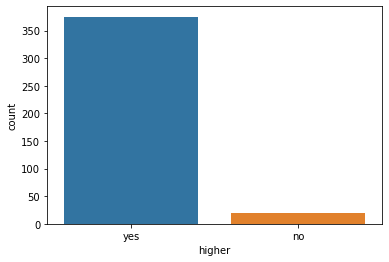

In [31]:
print(df['higher'].value_counts())
sns.countplot(x='higher', data=df)
plt.show()

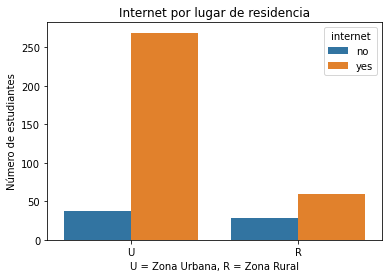

In [32]:
sns.countplot(x='address', hue='internet', data=df)
plt.title('Internet por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

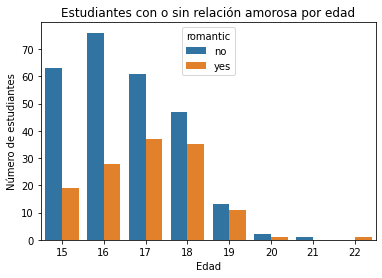

In [33]:
sns.countplot(x='age', hue='romantic', data=df)
plt.title('Estudiantes con o sin relación amorosa por edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

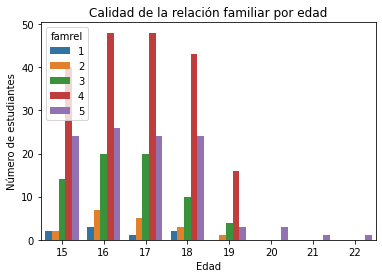

In [35]:
sns.countplot(x='age', hue='famrel', data=df)
plt.title('Calidad de la relación familiar por edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

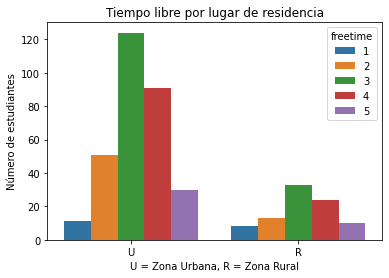

In [36]:
sns.countplot(x='address', hue='freetime', data=df)
plt.title('Tiempo libre por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

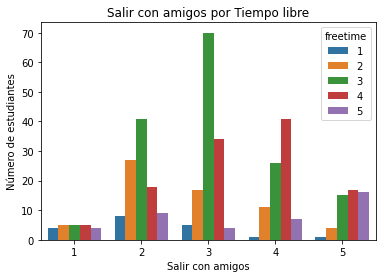

In [37]:
#going out with friends (numeric: from 1 - very low to 5 - very high)
#free time after school (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='goout', hue='freetime', data=df)
plt.title('Salir con amigos por Tiempo libre')
plt.xlabel('Salir con amigos')
plt.ylabel('Número de estudiantes')
plt.show()

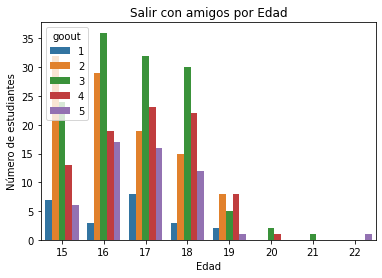

In [38]:
#going out with friends (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='age', hue='goout', data=df)
plt.title('Salir con amigos por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

1    276
2     75
3     26
5      9
4      9
Name: Dalc, dtype: int64


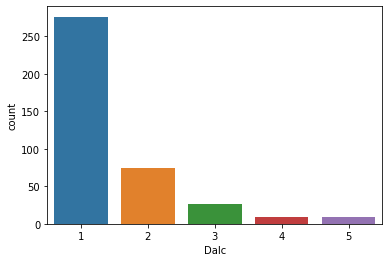

In [39]:
#workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
print(df['Dalc'].value_counts())
sns.countplot(x='Dalc', data=df)
plt.show()

1    151
2     85
3     80
4     51
5     28
Name: Walc, dtype: int64


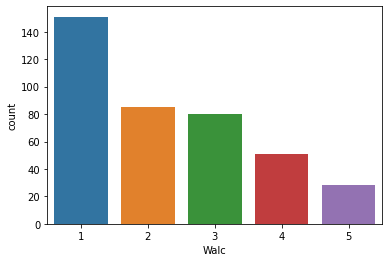

In [40]:
#weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
print(df['Walc'].value_counts())
sns.countplot(x='Walc', data=df)
plt.show()

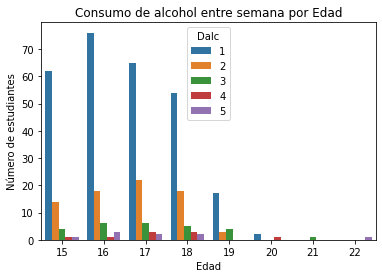

In [41]:
#workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='age', hue='Dalc', data=df)
plt.title('Consumo de alcohol entre semana por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

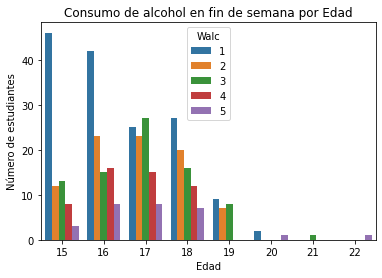

In [42]:
#weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='age', hue='Walc', data=df)
plt.title('Consumo de alcohol en fin de semana por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

5    146
3     91
4     66
1     47
2     45
Name: health, dtype: int64


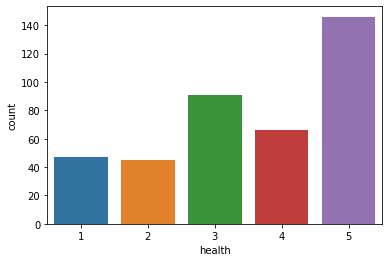

In [43]:
#current health status (numeric: from 1 - very bad to 5 - very good)
print(df['health'].value_counts())
sns.countplot(x='health', data=df)
plt.show()

<AxesSubplot:xlabel='absences'>

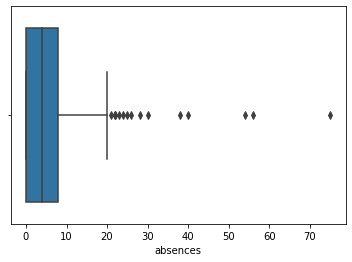

In [44]:
sns.boxplot(x="absences", data=df)

Text(0.5, 0, 'Calificaciones')

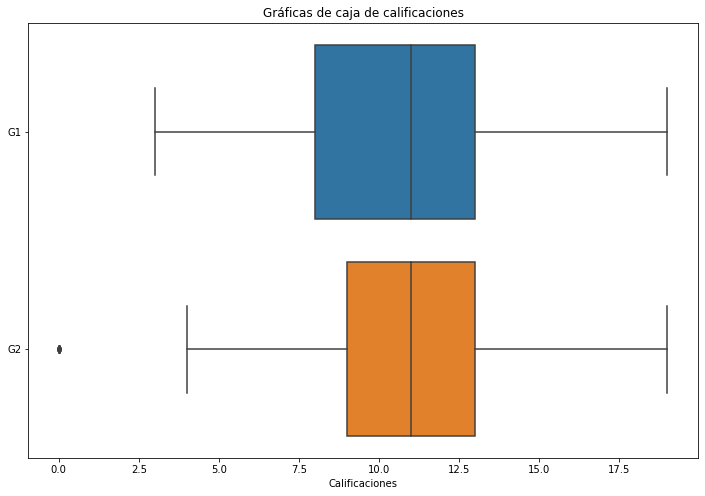

In [45]:
plt.figure(figsize=(12,8))
sns.boxplot(orient="h",data=df[['G1','G2']])
plt.title('Gráficas de caja de calificaciones')
plt.xlabel('Calificaciones')

<AxesSubplot:title={'center':'Calificaciones del primer parcial de acuerdo a las horas de estudio'}, xlabel='G1', ylabel='studytime'>

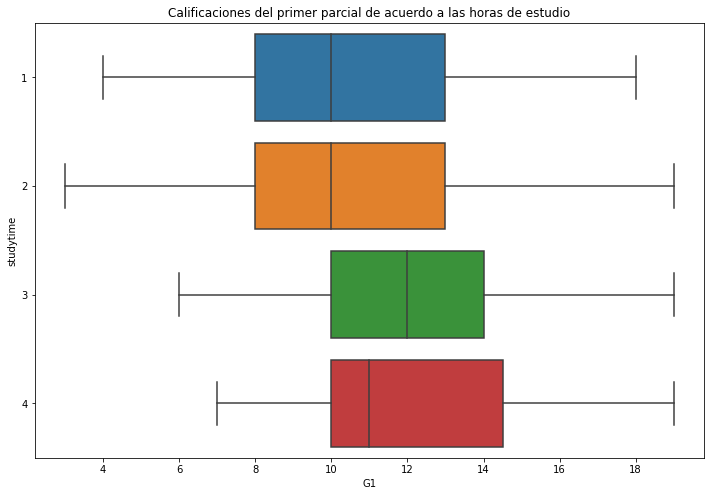

In [46]:
plt.figure(figsize=(12,8))
plt.title("Calificaciones del primer parcial de acuerdo a las horas de estudio")
sns.boxplot(y="studytime", x="G1", data = df , orient="h")

<AxesSubplot:title={'center':'Calificaciones del segundo parcial de acuerdo a las horas de estudio'}, xlabel='G2', ylabel='studytime'>

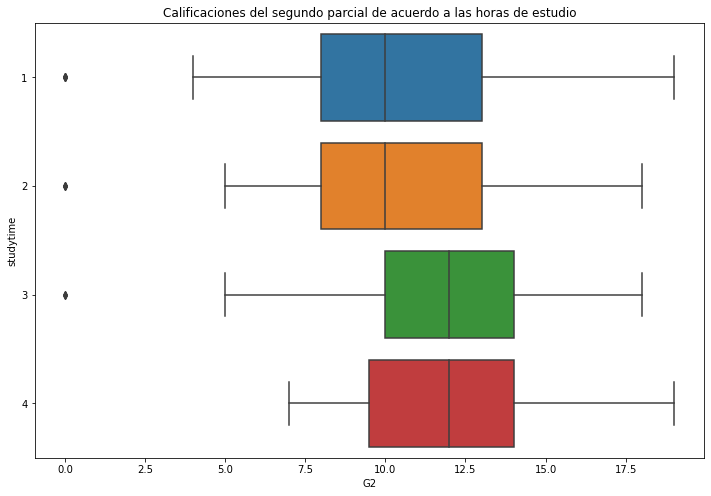

In [47]:
plt.figure(figsize=(12,8))
plt.title("Calificaciones del segundo parcial de acuerdo a las horas de estudio")
sns.boxplot(y="studytime", x="G2", data = df , orient="h")

<AxesSubplot:title={'center':'Calificaciones finales de acuerdo a las personas que quieren o no seguir estudiando'}, xlabel='G3', ylabel='higher'>

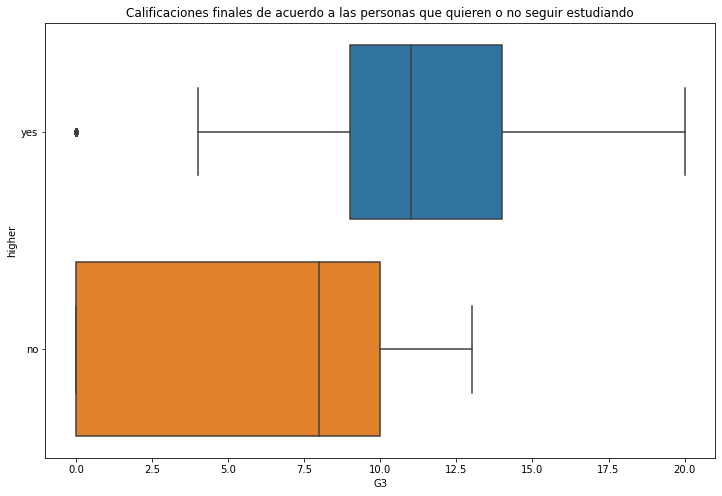

In [48]:
plt.figure(figsize=(12,8))
plt.title("Calificaciones finales de acuerdo a las personas que quieren o no seguir estudiando")
sns.boxplot(y="higher", x="G3", data = df , orient="h")